In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_confusion_matrix, binary_f1_score, multiclass_f1_score
from copy import deepcopy
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader

from few_shot_learning_nlp.few_shot_text_classification.pattern_exploiting import PETTrainer
from few_shot_learning_nlp.few_shot_text_classification.pattern_exploiting_dataset import PETDatasetForClassification
from few_shot_learning_nlp.utils import stratified_train_test_split
from few_shot_learning_nlp.loss import FocalLoss
from typing import List
    
import warnings
warnings.filterwarnings("ignore")

In [3]:

model_name = "PET"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading dataset

In [4]:
ag_news_dataset = load_dataset(
    "ag_news", 
    cache_dir= "/Data/pedro.silva"
)

In [5]:
classes = np.unique(ag_news_dataset['train']['label'], return_counts=True)
classes

(array([0, 1, 2, 3]), array([30000, 30000, 30000, 30000]))

## Few shot learning study - 50 shots

In [6]:
classes = np.unique(ag_news_dataset['train']['label'])
train_validation, test_df = stratified_train_test_split(
    ag_news_dataset['train'],
    classes,
    train_size = 50
)

In [7]:
train_df, val_df  = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [8]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [9]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return f"{tokenizer.mask_token} news: {text}"

In [10]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")

class_names = ag_news_dataset['train']\
    .features['label']\
    .names

class_names[3] = "Science"

num_classes = len(class_names)
num_classes

classes2idx = {
    label: idx for idx, label in enumerate(class_names) 
}

idx2classes = {
    idx: label for idx, label in enumerate(class_names) 
}

verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [11]:
verbalizer

{0: 2088, 1: 2998, 2: 2449, 3: 2671}

In [12]:

def preprocess(text : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2classes[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern1(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [13]:
train_text, train_labels = preprocess(train_df['text'], train_df['label'])
val_text, val_labels = preprocess(val_df['text'], val_df['label'])
test_text, test_labels = preprocess(test_df['text'], test_df['label'])

In [14]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

28it [00:00, 173.42it/s]
20it [00:00, 176.71it/s]
1000it [00:05, 181.00it/s]


In [15]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [16]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val_df['label'],
    return_counts=True,
)
alpha_val = len(val_df['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test_df['label'],
    return_counts=True,
)
alpha_test = len(test_df['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([4., 4., 4., 4.]),
 array([4., 4., 4., 4.]),
 array([3.58422939, 4.25531915, 4.01606426, 4.21940928]))

In [19]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)

trainer = PETTrainer(
    model,
    verbalizer,
    tokenizer,
    num_classes=len(classes)
)

history, confusion_matrix, best_model = trainer.train(
    train_dataloader, 
    val_dataloader, 
    alpha = 1e-6,
    loss_fn= FocalLoss(alpha, gamma=1),
    lr = 1e-4,
    device=device
)

Epoch 9
f1-score : 0.8500000238418579
tensor([[3, 0, 2, 0],
        [0, 5, 0, 0],
        [0, 0, 5, 0],
        [0, 0, 1, 4]], device='cuda:0')


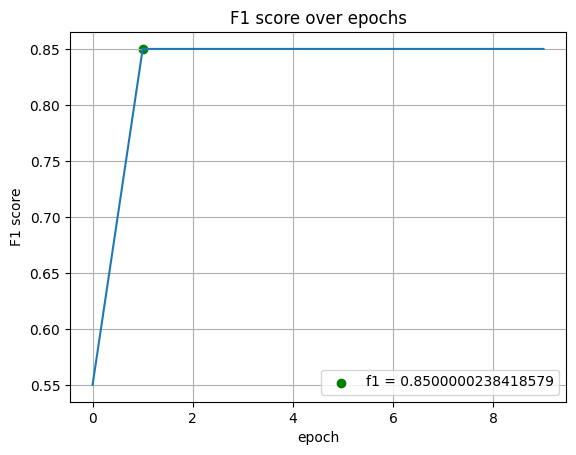

In [20]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix Ag news - PET')

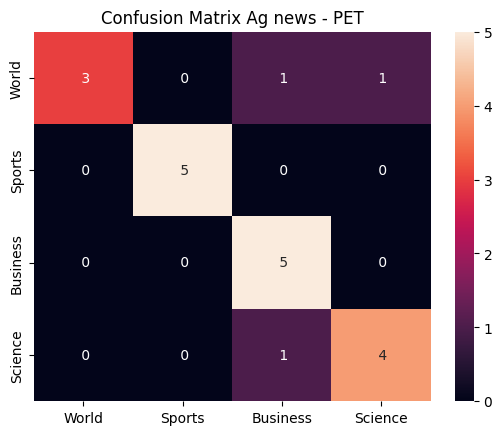

In [27]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix Ag news - PET")

## Test results

In [24]:
y_true_test, y_pred_test = trainer.test(
    test_dataloader
)

f1 = multiclass_f1_score(
    y_pred_test,
    y_true_test,
    num_classes= len(classes)
)
f1

100%|██████████| 1000/1000 [00:08<00:00, 118.24it/s]


tensor(0.8160, device='cuda:0')

Text(0.5, 1.0, 'Confusion Matrix Ag news - PET')

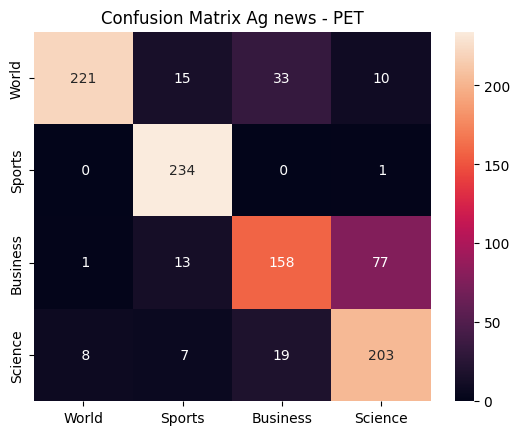

In [26]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(classes)
)

df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix Ag news - PET")